# Medical image captioning
The ROCC dataset was created by Pelka et al. (2018)1, aiming at detecting the interplay between visual elements and semantic relations present in radiology images. The dataset could be used for multi-modal image representations in classification tasks, for multi-class image classification and labeling, as well as medical image captioning. It was constructed by retrieving all image-caption pairs from the open-access biomedical literature database PubMedCentral and then, eliminating irrelevant images using a binary radiology and non-radiology classification. The dataset contains 81k radiology images with several medical imaging modalities and was used for ImageCLEF 2015 Medical Classification, and ImageCLEF 2013/2016 Medical Task. The dataset can be downloaded from https://www.kaggle.com/datasets/virajbagal/roco-dataset?select=all_data. The dataset repository includes three sets: train, validation, and test, where each of them consists of two folders: non-radiology and radiology. Restrict the data to be used for this project to the following structure (you do not need the remaining flies):

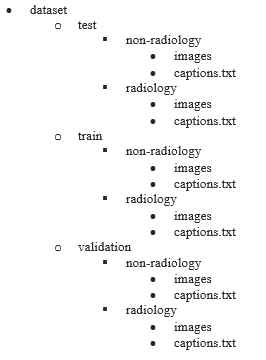

## 0. Imports and workspace setup.

In [ ]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import pathlib, os, cv2
import pandas as pd
import numpy as np, array
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from itertools import islice
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout, Bidirectional, Add
from keras import layers, models, Model, optimizers,mixed_precision, Input, optimizers
from keras.utils.layer_utils import count_params
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import string
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
import plotly
import numpy as np
import plotly.graph_objs as go
from sklearn.manifold import TSNE
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings 
warnings.filterwarnings(action = 'ignore') 
import gensim
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from sklearn.manifold import TSNE
from keras.utils import to_categorical
from keras.layers import BatchNormalization
import pickle
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#use your path to download the dataset
!unzip /content/drive/MyDrive/Natural\ Language\ Processing/projectDataset

## 1. Download the dataset and visualize some training image/caption pairs of your choice (radiology).

In [ ]:
#load the images' name from some files that we created in order to have images that actually are in the dataset
train_img = pd.read_csv('/content/drive/MyDrive/Natural Language Processing/img_training.csv', header=None)
test_img = pd.read_csv('/content/drive/MyDrive/Natural Language Processing/img_tes.csv', header=None)
val_img = pd.read_csv('/content/drive/MyDrive/Natural Language Processing/img_val.csv', header=None)

#load the featerus extracted from the images
train_features = pd.read_csv('/content/drive/MyDrive/Natural Language Processing/features_training.csv', header=None)
test_featurs = pd.read_csv('/content/drive/MyDrive/Natural Language Processing/feature_test.csv', header=None)
val_features = pd.read_csv('/content/drive/MyDrive/Natural Language Processing/features_val.csv', header=None)

#load the files with the pairs (img_name_img_description)
train_test = pd.read_csv('/content/all_data/train/radiologytraindata.csv')
val = pd.read_csv('/content/all_data/validation/radiologyvaldata.csv')
train_test_captions_ = train_test['caption']
val_captions_ = val['caption']

val_features = val_features.iloc[1: , :]
train_features = train_features.iloc[1: , :]
test_featurs = test_featurs.iloc[1: , :]

val_features.drop(columns=[0],inplace=True)
train_features.drop(columns=[0],inplace=True)
test_featurs.drop(columns=[0],inplace=True)

list_img_training = list(train_img[1])[1:]
list_img_test = list(test_img[1])[1:]
list_img_val = list(val_img[1])[1:]

In [ ]:
#creates 3 dictionaries (one for train, one for test and one for validation)
#each dictionary has as keys images' names and as value images' feature vector
def get_feature_dictionary(list_of_images_name, images_feature):
  i = 0
  new_dict = {}
  for key in list_of_images_name:
    new_dict[key] = images_feature.iloc[[i]].to_numpy()
    i=i+1
  return new_dict

train_features_new = get_feature_dictionary(list_img_training, train_features)
test_features_new = get_feature_dictionary(list_img_test, test_featurs)
val_features_new = get_feature_dictionary(list_img_val, val_features)

In [ ]:
#extract the labels of our images from the dataset and add to the a start token as weel as an end token
def get_true_labels(list_images, dataframe):
  i=0
  return_list=[]
  for name in list_images:
    found=False
    while not found:
      new_name = dataframe['name'][i]
      if name == new_name:
        return_list.append('startseq' + dataframe['caption'][i].replace('\n','') + ' endseq')
        found=True
      i=i+1
  return return_list

true_train_labels = get_true_labels(list_img_training, train_test)
true_test_labels = get_true_labels(list_img_test, train_test)
true_val_labels = get_true_labels(list_img_val, val)


In [ ]:
#create 3 datafames with 2 columns each: name and caption
train_dataframe=pd.DataFrame(list(zip(list_img_training, true_train_labels)),columns =['name', 'caption'])
test_dataframe=pd.DataFrame(list(zip(list_img_test, true_test_labels)),columns =['name', 'caption'])
val_dataframe=pd.DataFrame(list(zip(list_img_val, true_val_labels)),columns =['name', 'caption'])

#use the dataframes to easyli create 3 dictionaries with images' name as keys and images' caption as value
def img_capt(dataframe, path):
  descriptions ={}
  for i in range(0,len(dataframe)):
      if os.path.exists(path + dataframe['name'][i]):
        name = dataframe['name'][i]
        descriptions[name] = dataframe['caption'][i]
  return descriptions

train_path = '/content/all_data/train/radiology/images/'
validation_path = '/content/all_data/validation/radiology/images/'
test_path = train_path

descriptions_train=img_capt(train_dataframe, train_path)
descriptions_test=img_capt(test_dataframe,test_path)
descriptions_val=img_capt(val_dataframe,validation_path)

In [ ]:
#we reduced the size of the train dataset to 40000 elements
# and to do so we ordered the dataset to keep the images with an appropriate value of the caption's length 
#(not too short, not too long)

import collections
def order_rule(elem):
  return len(elem[1].split())

def created_sorted_dicts(descriptions_train, descriptions_test, descriptions_val):
  sorted_descriptions_train = sorted(descriptions_train.items(), key=order_rule)
  sorted_descriptions_train = collections.OrderedDict(sorted_descriptions_train)

  sorted_descriptions_test = sorted(descriptions_test.items(), key=order_rule)
  sorted_descriptions_test = collections.OrderedDict(sorted_descriptions_test)

  sorted_descriptions_val = sorted(descriptions_val.items(), key=order_rule)
  sorted_descriptions_val = collections.OrderedDict(sorted_descriptions_val)

  sorted_descriptions_train = dict(sorted_descriptions_train)
  sorted_descriptions_test = dict(sorted_descriptions_test)
  sorted_descriptions_val = dict(sorted_descriptions_val)

  sorted_descriptions_train_list = list(islice(sorted_descriptions_train.items(), 46000))[6000:]#11000
  sorted_descriptions_test_list = list(islice(sorted_descriptions_test.items(), 7500))[3500:]
  sorted_descriptions_val_list = list(islice(sorted_descriptions_val.items(), 6500))[2500:]

  sorted_descriptions_train = dict(sorted_descriptions_train_list)
  sorted_descriptions_test = dict(sorted_descriptions_test_list)
  sorted_descriptions_val = dict(sorted_descriptions_val_list)
  return (sorted_descriptions_train, sorted_descriptions_test, sorted_descriptions_val),(sorted_descriptions_train_list,sorted_descriptions_test_list,sorted_descriptions_val_list)

(sorted_descriptions_train, sorted_descriptions_test, sorted_descriptions_val),(sorted_descriptions_train_list,sorted_descriptions_test_list,sorted_descriptions_val_list) = created_sorted_dicts(descriptions_train, descriptions_test, descriptions_val)

Text(0.5, 1.0, 'Case 3: pneumonia diagnosed via chest X-ray.')

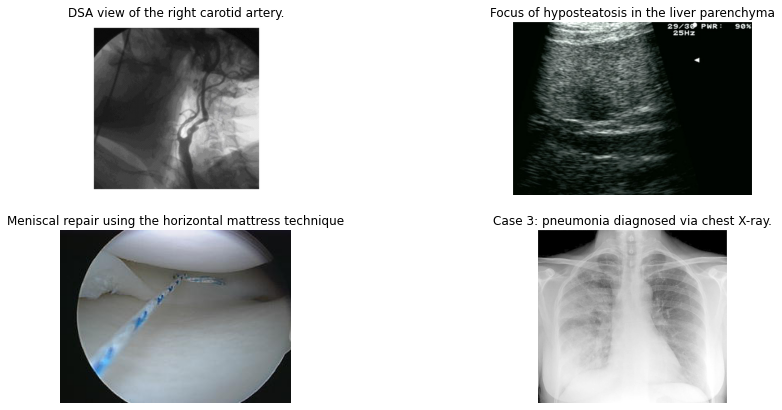

In [ ]:
rows = 2
columns = 2
fig = plt.figure(figsize=(15, 7))

fig.add_subplot(rows, columns, 1)  
plt.imshow(plt.imread(train_path + sorted_descriptions_train_list[101][0]), cmap='gray')
plt.axis('off')
plt.title(sorted_descriptions_train_list[101][1][9:-7])
  
fig.add_subplot(rows, columns, 2)
plt.imshow(plt.imread(train_path + sorted_descriptions_train_list[111][0]), cmap='gray')
plt.axis('off')
plt.title(sorted_descriptions_train_list[111][1][9:-7])
  
fig.add_subplot(rows, columns, 3)
plt.imshow(plt.imread(train_path + sorted_descriptions_train_list[121][0]), cmap='gray')
plt.axis('off')
plt.title(sorted_descriptions_train_list[121][1][9:-7])
  
fig.add_subplot(rows, columns, 4)
plt.imshow(plt.imread(train_path + sorted_descriptions_train_list[131][0]), cmap='gray')
plt.axis('off')
plt.title(sorted_descriptions_train_list[131][1][9:-7])


##  2. Keep the encoder and decoder architectures as the example (you can change the densnet121 into another pretrained model such as vgg16 or resnet50).


In [ ]:
#here there is the decoder
def get_model(dropout):
  inputs1 = Input(shape=(2048,))
  fe1 = Dropout(dropout)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)

  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
  se2 = Dropout(dropout)(se1)

  se3 = LSTM(256,return_sequences=True)(se2)
  se3 = BatchNormalization()(se3)
  se3 = Dropout(dropout)(se3)
  se3 = LSTM(256,return_sequences=True)(se3)
  se3 = BatchNormalization()(se3)
  se3 = Dropout(dropout)(se3)
  se3 = LSTM(256)(se3)
  se3 = BatchNormalization()(se3)
  se3 = Dropout(dropout)(se3)

  decoder1 = Add()([fe2, se3])
  decoder2 = Dense(2048, activation='relu')(decoder1)
  decoder2 = Dropout(dropout)(decoder2)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)

  return Model(inputs=[inputs1, inputs2], outputs=outputs)

 ## 3. Create the vocabulary from the ROCO dataset (you can limit to only 2500 images and their captions for the training set and 500 for the validation set):
*   First, clean the captions by punctuation removal, stop words removal, lowercasing, tokenization and stemming.
*   Plot the word occurrence frequency curve after ranking the tokens. Check whether a power-law distribution can be fitted or not by plotting the log-log curve. Explain the results.
*   Calculate embeddings for the captions using word2vec and glove.
*   Visualize part of the word embedding space. Explain the results.







In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

#### Cleaning captions with appropriate operations

In [ ]:
def remove_stopwords(input_text):
    removed = [token for token in input_text if token.lower() not in stopwords.words('english')]
    return removed

def remove_punctuation(input_text):
    return [token for token in input_text if token not in set(string.punctuation)]

def lemmatize(input_text):
    # Instantiate class
    lem = WordNetLemmatizer()
    # Lemmatized text becomes input inside all loop runs
    lemmatized_text = input_text
    # Lemmatize each part of speech
    for part_of_speech in ['n', 'v', 'a', 'r', 's']:
        lemmatized_text = [lem.lemmatize(token, part_of_speech).lower() for token in lemmatized_text]
    return lemmatized_text


def stem(input_text):
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(token) for token in input_text]

def clean_list_of_text(
        input_text, 
        enable_stopword_removal=True,
        enable_punctuation_removal=True,
        enable_lemmatization=True,
        enable_stemming=True
    ):
    # Get list of operations
    enabled_operations = [word_tokenize]
    if enable_stopword_removal:
        enabled_operations.append(remove_stopwords)
    if enable_punctuation_removal:
        enabled_operations.append(remove_punctuation)
    if enable_lemmatization:
        enabled_operations.append(lemmatize)
    if enable_stemming:
        enabled_operations.append(stem)
    #print(f'Enabled Operations: {len(enabled_operations)}')
    cleaned_text_lines = input_text
    for operation in enabled_operations:
        for key in cleaned_text_lines:
          cleaned_text_lines[key] = operation(cleaned_text_lines[key])
    
    for key in cleaned_text_lines:
      new_val=''
      i=0
      for elem in cleaned_text_lines[key]:
        new_val = new_val + elem  
        if i < len(cleaned_text_lines[key]) - 1:
          new_val += ' '
        i=i+1
      cleaned_text_lines[key] = new_val
    return cleaned_text_lines

# Example of applying the function
descriptions_train = clean_list_of_text(sorted_descriptions_train)
descriptions_test = clean_list_of_text(sorted_descriptions_test)
descriptions_val = clean_list_of_text(sorted_descriptions_val)

In [ ]:
def txt_vocab(descriptions):
  # To build vocab of all unique words
  vocab = set()
  for key in descriptions.keys():
      vocab.update(descriptions[key].split())
  return vocab

In [ ]:
vocabulary_train = txt_vocab(descriptions_train)
vocabulary_test = txt_vocab(descriptions_test)
vocabulary_val = txt_vocab(descriptions_val)
vocabulary=(vocabulary_train.union(vocabulary_test)).union(vocabulary_val)

In [ ]:
print('words in train vocabulary:',len(vocabulary_train))
print('words in test vocabulary:',len(vocabulary_test))
print('words in validation vocabulary:',len(vocabulary_val))
print('words in the onion of the 3 vocabularies:',len(vocabulary))

words in train vocabulary: 22927
words in test vocabulary: 6843
words in validation vocabulary: 6924
words in the onion of the 3 vocabularies: 24198


In [ ]:
def get_new_descriptions(desc):
  lines = list()
  for key, desc in desc.items():
      lines.append(key + ' ' + desc)
  new_descriptions = '\n'.join(lines)
  return new_descriptions

new_descriptions_train = get_new_descriptions(descriptions_train)
new_descriptions_test = get_new_descriptions(descriptions_test)
new_descriptions_val = get_new_descriptions(descriptions_val)

train_descriptions = dict()
for line in new_descriptions_train.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    train_descriptions[image_id] = list()
    train_descriptions[image_id].append(' '.join(image_desc))
  
all_train_captions = []
for key, val in train_descriptions.items():
        all_train_captions.append(val)

In [ ]:
#Takes only the words that in the train set are present for at least 15 times
word_count_threshold = 15
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    sent=sent[0]
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 2778


In [ ]:
#create two dictionaries, the former to convert an word to 
#an index and the latter to convert an index to a word

wordtoix = {}
ixtoword = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1
print('vocab size:',vocab_size)

vocab size: 2779


In [ ]:
#find the longest (number of words) caption in the train set
all_desc = list()
for key in train_descriptions.keys():
    all_desc.append(train_descriptions[key])
lines = all_desc
max_length = max(len(d[0].split()) for d in lines)

print('Captions max length: %d' % max_length)

Captions max length: 34


In [ ]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
!unzip -q glove.6B.zip

--2022-11-06 08:29:41--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
Resolving huggingface.co (huggingface.co)... 34.227.129.17, 52.3.185.208, 2600:1f18:147f:e850:db19:5c51:ec6e:ddca, ...
Connecting to huggingface.co (huggingface.co)|34.227.129.17|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/6471382cdd837544bf3ac72497a38715e845897d265b2b424b4761832009c837?response-content-disposition=attachment%3B%20filename%3D%22glove.6B.zip%22&Expires=1667982582&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3N0YW5mb3JkbmxwL2dsb3ZlLzY0NzEzODJjZGQ4Mzc1NDRiZjNhYzcyNDk3YTM4NzE1ZTg0NTg5N2QyNjViMmI0MjRiNDc2MTgzMjAwOWM4Mzc~cmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj1hdHRhY2htZW50JTNCJTIwZmlsZW5hbWUlM0QlMjJnbG92ZS42Qi56aXAlMjIiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE2Njc5ODI1ODJ9fX1dfQ__&Signature=YJAcnlh9FD9JI7p2m~91IOQV3GBHcK2aI6hUrRqk2qiO4qsjqaJr

In [ ]:
embeddings_index = {} 
f = open('/content/glove.6B.200d.txt', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#### Plotting the occurrence frequency curve and the log-log scale curve

   words  count
0   show  21068
1  arrow   9692
2   leav   8446
3   imag   8378
4  right   8231


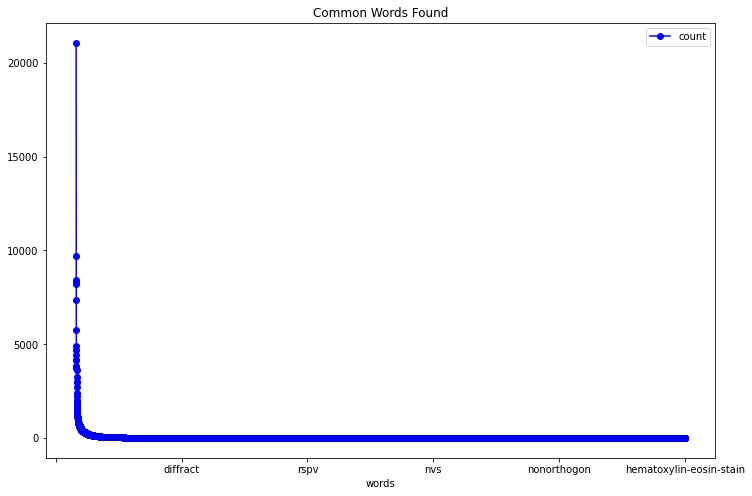

In [ ]:

def count_words(txt):
  cnt = Counter()
  for text in txt:    
    for tt in text:      
      cnt[tt] += 1
  return cnt
  
def split_list(list):
  newlist = []
  for sentence in list:
    sentence = sentence.replace('startseq', '')
    sentence = sentence.replace('endseq', '')
    newlist.append(sentence.split())
      
  return newlist

# descriptions_train and descriptions_val are not lists because they are taken from a dictionary, so 
# we transform them into lists and use the split function to create lists of words

one = split_list(list(descriptions_train.values()))
two = split_list(list(descriptions_val.values()))

merged =  one + two

# we obtain a Counter object to visualize the vocabulary

words = count_words(merged)

sample_n = len(words)

word_freq = pd.DataFrame(words.most_common()[:sample_n],columns=['words', 'count'])
print(word_freq.head())
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar graph
word_freq.sort_values(by='count').plot(x='words',y='count',marker = 'o', color='blue',ax=ax )
ax.set_title("Common Words Found")
ax.invert_xaxis()
plt.show()


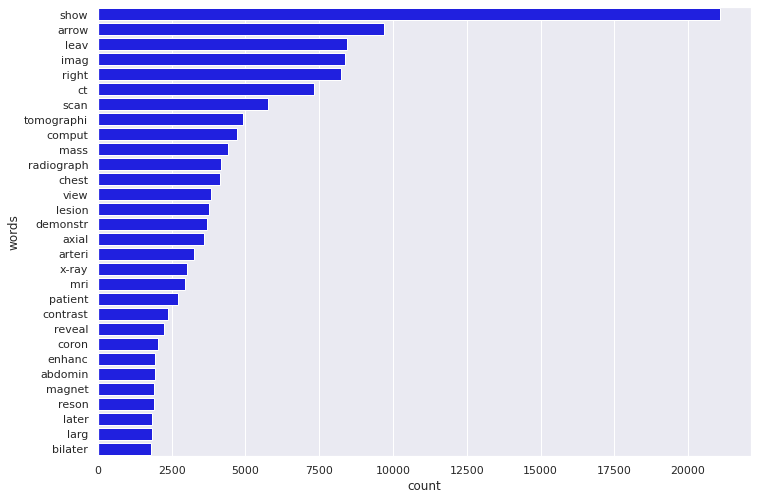

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x='count',y='words',data=word_freq.head(30),color = 'blue')

We also plot the log-log scale in order to understand if a power law could be fitted

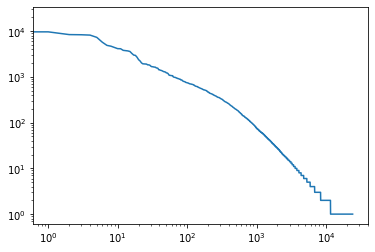

In [ ]:
plt.loglog(np.arange(0,sample_n), word_freq['count'])

#### Calculating embeddings for the captions using word2vec

In [ ]:
# creating  a word2vec model to be trained with our vocabulary (merged)

model_1 = Word2Vec(merged, min_count=1,size= 50,workers=3, window =3, sg = 1)

In [ ]:
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]

    close_words = model.similar_by_word(word)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [ ]:
# we want to print the similarity scoreds between the printed words

print(model_1.similarity('hand', 'leg'))
print(model_1.similarity('hand', 'tumor'))
print(model_1.similarity('leg', 'tumor'))

0.8498713
0.39230272
0.43242317


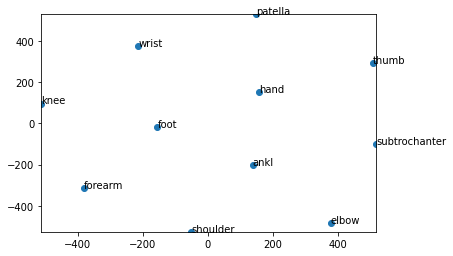

In [ ]:
display_closestwords_tsnescatterplot(model_1, 'hand', 50)

Calculate embeddings for the captions using glove and word2vect

#### Using GloVe to plot the word space

In [ ]:
glove_file = '/content/glove.6B.50d.txt'
word2vec_output_file = f'glove.6B.50.txt'+'.word2vec'
glove2word2vec(glove_file, word2vec_output_file)

# we create a model with glove pre trained vectors to have a different visual perspective on our vocabulary  

model_2 = KeyedVectors.load_word2vec_format(word2vec_output_file)

filename = 'glove2word2vec_model.sav'

In [ ]:
print(model_2.similarity('hand', 'leg'))
print(model_2.similarity('hand', 'tumor'))
print(model_2.similarity('leg', 'tumor'))

0.61864364
0.25729775
0.26887867


In [ ]:
def append_list(sim_words, words):    
  
    list_of_words = []    
    for i in range(len(sim_words)):
        
        sim_words_list = list(sim_words[i])
        sim_words_list.append(words)
        sim_words_tuple = tuple(sim_words_list)
        list_of_words.append(sim_words_tuple)
        
    return list_of_words

In [ ]:
def obtain_dict(model, user_input):   
  result_word = [] 
  for words in user_input:
      
          sim_words = model.most_similar(words, topn = 5)
          sim_words = append_list(sim_words, words)              
          result_word.extend(sim_words)

  similar_word = [word[0] for word in result_word]
  similarity = [word[1] for word in result_word] 
  similar_word.extend(user_input)
  labels = [word[2] for word in result_word]
  label_dict = dict([(y,x+1) for x,y in enumerate(set(labels))])
  color_map = [label_dict[x] for x in labels] 
  return similar_word, similarity, labels, label_dict, color_map

In [ ]:
def display_tsne_scatterplot_2D(model, user_input=None, words=None, label=None, color_map=None, perplexity = 0, learning_rate = 0, iteration = 0, topn=5, sample=10):

    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
    
    word_vectors = np.array([model[w] for w in words])
    
    


    # For 2D, change the three_dim variable into something like two_dim like the following:
    two_dim = TSNE(n_components = 2, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors)[:,:2]

    data = []


    count = 0
    for i in range (len(user_input)):

                trace = go.Scatter(
                    x = two_dim[count:count+topn,0], 
                    y = two_dim[count:count+topn,1],  
                    #z = three_dim[count:count+topn,2],
                    text = words[count:count+topn],
                    name = user_input[i],
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 0.8,
                        'color': 2
                    }
       
                )
                
                )
            
                data.append(trace)
                count = count+topn

    trace_input = go.Scatter(
                    x = two_dim[count:,0], 
                    y = two_dim[count:,1],  
                    text = words[count:],
                    name = 'input words',
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 1,
                        'color': 'black'
                    }
                    )

    
            
    data.append(trace_input)
    
# Configure the layout

    layout = go.Layout(
        margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(
        x=1,
        y=0.5,
        font=dict(
            family="Courier New",
            size=25,
            color="black"
        )),
        font = dict(
            family = " Courier New ",
            size = 15),
        autosize = False,
        width = 1000,
        height = 1000
        )


    plot_figure = go.Figure(data = data, layout = layout)
    plot_figure.show()    


### Plotting the space of embedded words using word2vec

In [ ]:
user_input = ['hand','tumor','leg']
similar_word, similarity, labels, label_dict, color_map = obtain_dict(model_1,user_input)
display_tsne_scatterplot_2D(model_1, user_input, similar_word, labels, color_map, 5, 500, 10000)

### Plotting the space of embedded words using GloVe

In [ ]:
user_input = ['hand','tumor','leg']
similar_word, similarity, labels, label_dict, color_map = obtain_dict(model_2, user_input)
display_tsne_scatterplot_2D(model_2, user_input, similar_word, labels, color_map, 5, 500, 10000)

## 4. Create train_data_loader and val_data_loader from the training and validation sets, respectively. The loaders allow us to load the images and their associated captions to the model by batches.


In [ ]:

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch,flag):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while True:
        for key, desc in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            # encode the sequence
            seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
            # split one sequence into multiple X, y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photo)
                X2.append(in_seq)
                y.append(out_seq)

            if n==num_photos_per_batch:
                d1,d2,d3 = np.array(X1).shape
                yield ([np.array(X1).reshape(d1,d3), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
batch_size = 64
val_steps = len(new_descriptions_val) // batch_size
generator = data_generator(descriptions_train, train_features_new, wordtoix, max_length, batch_size,'t')
generator_val = data_generator(descriptions_val, val_features_new, wordtoix, max_length, batch_size,'v')

## 5. Change the training loop to train the implemented model using the ROCO dataset.


In [ ]:
epochs = 20
steps = len(descriptions_train) // batch_size
val_steps = len(descriptions_val) // batch_size

model = get_model(dropout=0.5)
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

import keras
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, verbose=0,monitor='val_loss'),
    keras.callbacks.ModelCheckpoint(
        filepath='nlp.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001, min_delta=0.00001)
]

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 34, 200)      555800      ['input_6[0][0]']                
                                                                                                  
 dropout_11 (Dropout)           (None, 34, 200)      0           ['embedding_2[0][0]']            
                                                                                                  
 lstm_6 (LSTM)                  (None, 34, 256)      467968      ['dropout_11[0][0]']             
                                                                                            

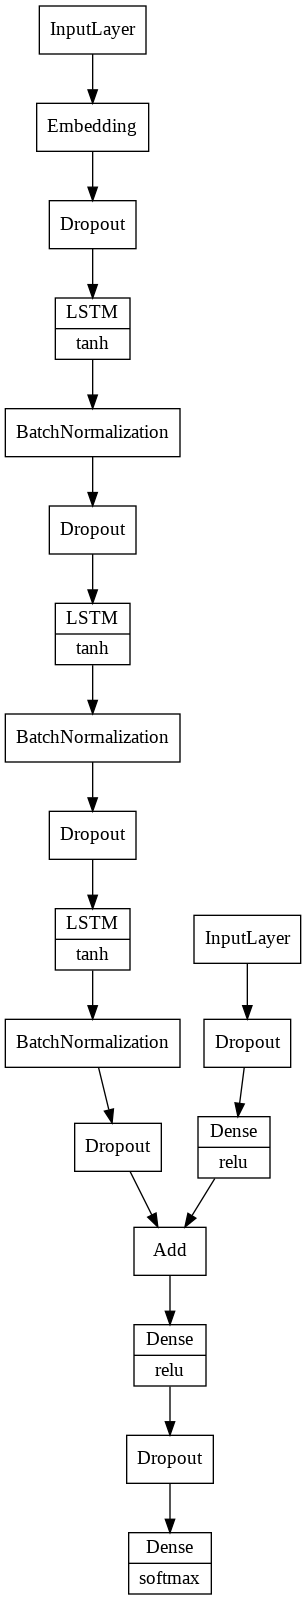

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam())
history = model.fit(
    generator, 
    epochs=epochs, 
    steps_per_epoch=steps, 
    validation_data=generator_val,
    validation_steps=val_steps,
    callbacks=callbacks)

Epoch 1/20
625/625 [==============================] - 157s 227ms/step - loss: 5.9214 - val_loss: 5.6994 - lr: 0.0010
Epoch 2/20
625/625 [==============================] - 138s 220ms/step - loss: 5.5489 - val_loss: 5.5061 - lr: 0.0010
Epoch 3/20
625/625 [==============================] - 138s 220ms/step - loss: 5.3714 - val_loss: 5.3745 - lr: 0.0010
Epoch 4/20
625/625 [==============================] - 137s 220ms/step - loss: 5.2431 - val_loss: 5.2556 - lr: 0.0010
Epoch 5/20
625/625 [==============================] - 138s 221ms/step - loss: 5.1425 - val_loss: 5.1741 - lr: 0.0010
Epoch 6/20
625/625 [==============================] - 138s 220ms/step - loss: 5.0569 - val_loss: 5.0924 - lr: 0.0010
Epoch 7/20
625/625 [==============================] - 138s 220ms/step - loss: 4.9894 - val_loss: 5.0428 - lr: 0.0010
Epoch 8/20
625/625 [==============================] - 137s 219ms/step - loss: 4.9310 - val_loss: 4.9899 - lr: 0.0010
Epoch 9/20
625/625 [==============================] - 137s 219ms

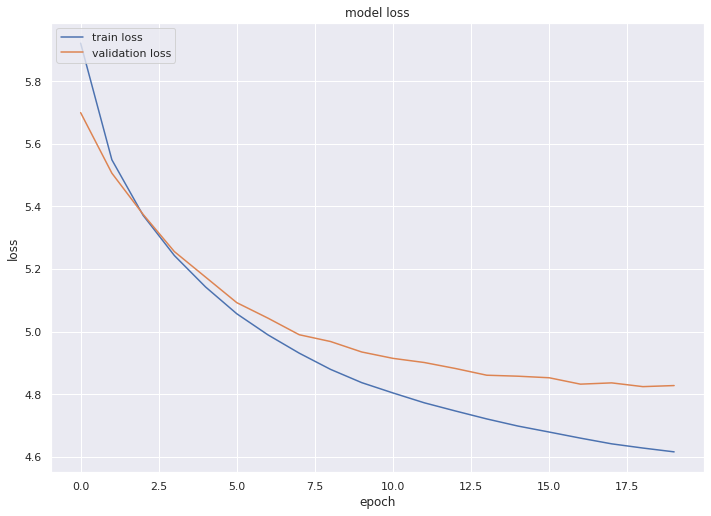

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.show()

## 6. Create a function to test your model on some samples from the test set (10 samples).


In [ ]:
#loading the best weights founded during the train 
model.load_weights('nlp.keras')

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def get_bleu_score(reference,target):
    return sentence_bleu(reference, target, weights=(1, 0, 0, 0))

## 7. Calculate the similarity between the newly generated captions and the original captions using three different metrics.


In [ ]:
def test_img(pic):
  test_path = train_path + pic
  image = test_features_new[pic].reshape((1,2048))
  x=plt.imread(train_path+pic)
  plt.axis('off')
  plt.imshow(x, cmap='gray')
  plt.show()

  y_true = descriptions_test[pic][9:]
  y_true = y_true[:-7]
  print('true label:',y_true)
  greedy = greedySearch(image)
  print("Greedy Search:",greedy)
  print('bleu score:',get_bleu_score([y_true.split()],greedy.split())*100,'%')
  scorer = rouge_scorer.RougeScorer(['rouge1'])
  score = scorer.score(greedy, y_true)
  precision, recall, fmeasure = score['rouge1']
  print('precision:',precision)
  print('recall:',recall)
  print('fmeasure:',fmeasure)

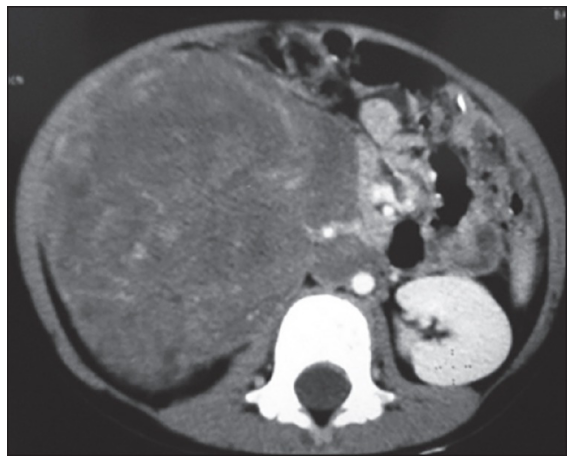

true label: comput tomograph ct scan abdomen diagnosi show larg right renal mass
Greedy Search: ct scan abdomen show larg mass right kidney arrow right kidney arrow
bleu score: 58.333333333333336 %
precision: 0.6363636363636364
recall: 0.5833333333333334
fmeasure: 0.6086956521739131


In [ ]:
test_img(list(descriptions_test.keys())[1070])

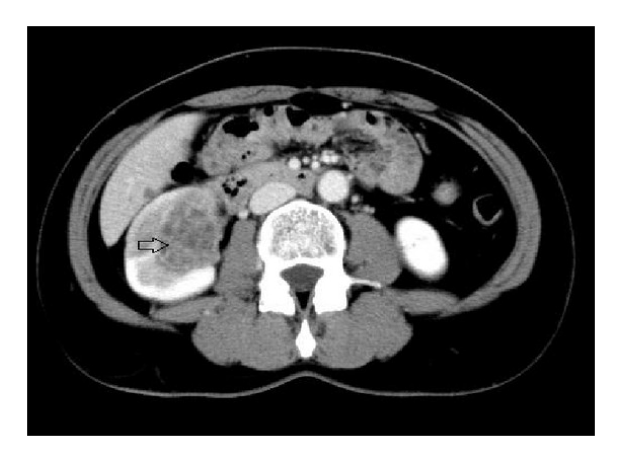

true label: ct scan imag abdomen show tumour arrow right kidney
Greedy Search: ct scan abdomen show larg mass right kidney arrow right kidney arrow right kidney
bleu score: 50.0 %
precision: 0.7777777777777778
recall: 0.5
fmeasure: 0.6086956521739131


In [ ]:
test_img(list(descriptions_test.keys())[434])

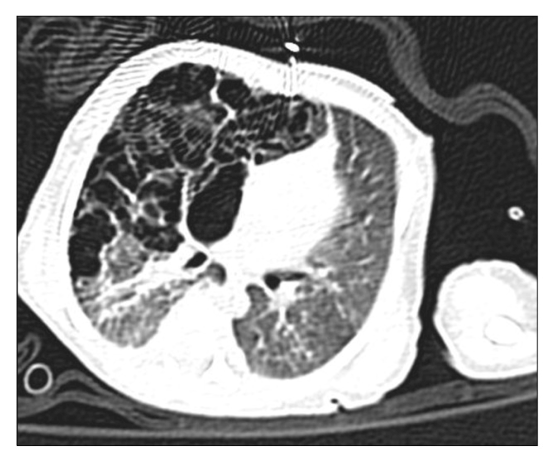

true label: chest comput tomographi scan show multipl thin-wal cyst right middl lobe
Greedy Search: chest comput tomographi scan show multipl right low lobe right lung field right lung
bleu score: 57.14285714285714 %
precision: 0.6666666666666666
recall: 0.5714285714285714
fmeasure: 0.6153846153846153


In [ ]:
test_img(list(descriptions_test.keys())[777])

In [ ]:
pics = list(descriptions_test.keys())
bleus=[]
pres = []
rec = []
fm = []
for key in pics:
  image = test_features_new[key].reshape((1,2048))
  y_true = descriptions_test[key][9:]
  y_true = y_true[:-7]
  greedy = greedySearch(image)
  bleus.append(get_bleu_score([y_true.split()],greedy.split()))
  scorer = rouge_scorer.RougeScorer(['rouge1'])
  score = scorer.score(greedy, y_true)
  precision, recall, fmeasure = score['rouge1']
  pres.append(precision)
  rec.append(recall)
  fm.append(fmeasure)

In [ ]:
print('mean bleus score:',np.mean(bleus)*100, '%')
print('mean precision:',np.mean(pres))
print('mean recall:',np.mean(rec))
print('mean fmeasure:',np.mean(fm))

mean bleus score: 14.286003160401595 %
mean precision: 0.16654677131357523
mean recall: 0.16244789408306545
mean fmeasure: 0.1614944601567775
